In [17]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from TA import *
import ccxt
from datetime import datetime, timedelta
import shap
from sklearn.model_selection import TimeSeriesSplit
import random


### Data Acquisition

This part gets the relavant data from Binance.

In [18]:
# 1. Data Acquisition
def create_raw_stock_dataset(symbol, time_interval, start_date):
    """Fetch OHLCV data from Binance using CCXT."""
    exchange = ccxt.binance()
    since = int(start_date.timestamp() * 1000)
    ohlcv = exchange.fetch_ohlcv(symbol, time_interval, since=since, limit=10000)
    data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    data.set_index('timestamp', inplace=True)
    return data

def fetch_data(symbol, time_interval, start_date, end_date=None):
    """Fetch data using create_raw_stock_dataset and handle pagination if needed."""
    start = pd.to_datetime(start_date)
    
    # Initial data fetch
    data = create_raw_stock_dataset(symbol, time_interval, start)
    
    # If end_date is specified and more data is needed, fetch in chunks
    if end_date is not None:
        end = pd.to_datetime(end_date)
        current_end = data.index[-1]
        
        # Continue fetching until we reach end_date or no more data
        while current_end < end and len(data) > 0:
            # Next fetch starts from the last timestamp + 1ms
            next_start = current_end + pd.Timedelta(milliseconds=1)
            next_data = create_raw_stock_dataset(symbol, time_interval, next_start)
            
            # Break if no new data
            if len(next_data) == 0:
                break
                
            # Append new data and update current end
            data = pd.concat([data, next_data])
            current_end = data.index[-1]
    
    # Ensure column names match expected format (capitalized first letter)
    data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    # Filter by end_date if specified
    if end_date is not None:
        data = data[data.index <= end_date]
    
    return data

### Feature Engineering

This part creates all the features we are going to use for the model.

In [19]:
def engineer_features(df):
    """Generate technical indicators and other features."""
    # Make a copy to avoid SettingWithCopyWarning
    data = df.copy()
    
    # Technical Indicators
    # Momentum indicators
    # RSI
    data['RSI'] = calculate_rsi(data['Close'], 14)

    # MACD
    data['MACD'], data['MACD_Signal'], data['MACD_Hist'] = calculate_macd(data['Close'])

    # stochastic
    data['Stoch_K'], data['Stoch_D'] = calculate_stoch(data)

    # Simple Moving Averages
    data['SMA20'] = data['Close'].rolling(window=20).mean()
    data['SMA50'] = data['Close'].rolling(window=50).mean()
    data['SMA200'] = data['Close'].shift(1).rolling(200).mean()

    # Exponential Moving Average
    data['EMA20'] = data['Close'].ewm(span=20, adjust=False).mean()

    # ADX
    data['ADX'] = calculate_adx(data.shift(1))

    # ATR
    data['ATR'] = calculate_atr(data)

    # Bollinger Bands
    data['BB_Upper'], data['BB_Middle'], data['BB_Lower'] = calculate_bbands(data)
    data['BB_Width'] = (data['BB_Upper'] - data['BB_Lower']) / data['BB_Middle']

    # OBV
    data['OBV'] = calculate_obv(data)
    
    # Calculate VWAP manually
    data['Typical_Price'] = (data['High'] + data['Low'] + data['Close']) / 3
    data['VP'] = data['Typical_Price'] * data['Volume']
    data['VWAP'] = data['VP'].rolling(window=20).sum() / data['Volume'].rolling(window=20).sum()
    
    # Lag features
    for lag in [1, 3, 7]:
        data[f'Return_Lag_{lag}'] = data['Close'].pct_change(lag)
    
    # Rolling statistics
    for window in [7, 30]:
        data[f'Std_Dev_{window}D'] = data['Close'].rolling(window=window).std()
        data[f'MA_{window}D'] = data['Close'].rolling(window=window).mean()
        data[f'Z_Score_{window}D'] = (data['Close'] - data[f'MA_{window}D']) / data[f'Std_Dev_{window}D']
    
    # Price relative to moving averages
    data['Close_Rel_SMA20'] = data['Close'] / data['SMA20'] - 1
    data['Close_Rel_SMA50'] = data['Close'] / data['SMA50'] - 1
    data['Close_Rel_SMA200'] = data['Close'] / data['SMA200'] - 1
    
    # Crossover signals
    data['SMA20_Cross_SMA50'] = (data['SMA20'] > data['SMA50']).astype(int)
    
    # Additional features
    data['High_Low_Range'] = data['High'] - data['Low']
    data['Close_Open_Range'] = abs(data['Close'] - data['Open'])
    data['Range_Ratio'] = data['Close_Open_Range'] / data['High_Low_Range']
    
    # Cryptocurrency-specific indicators
    # Logarithmic returns may work better for highly volatile assets
    data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
    
    # Volatility measures
    data['Volatility_30D'] = data['Log_Return'].rolling(window=30).std() * np.sqrt(30)
    
    # Drop rows with NaN values after feature engineering
    data = data.dropna()
    
    return data

### Target Engineering

This part is for creating the target variables used in model training and evaluation.

It calculates the future return over a specified prediction horizon (e.g., 5 days ahead).

For classification, it labels each row as 1 (positive signal) if the return exceeds a given threshold, and 0 otherwise.

After defining the targets, it drops rows with missing future return data due to shifting.

It also prepares the final feature matrix (X) and target vector (y) by removing irrelevant price columns.

In [20]:
def create_target_variable(df, prediction_horizon=5, threshold=0.005):
    """Create target variables for both regression and classification."""
    # Create future return column
    df[f'Future_Return_{prediction_horizon}D'] = df['Close'].pct_change(periods=prediction_horizon).shift(-prediction_horizon)

    # Classification: 1 if return > threshold, else 0
    df[f'Target_Binary_{prediction_horizon}D'] = (df[f'Future_Return_{prediction_horizon}D'] > threshold).astype(int)

    # Drop rows with missing future returns (from the shift)
    df = df.dropna(subset=[f'Future_Return_{prediction_horizon}D'])

    print("Available target columns:", df.columns[df.columns.str.contains("Target")])

    return df

def prepare_features_targets(df, prediction_horizon=5, classification=False):
    """Prepare features and target for modeling."""
    # Define target
    if classification:
        target_col = f'Target_Binary_{prediction_horizon}D'
    else:
        target_col = f'Future_Return_{prediction_horizon}D'
    
    # Drop irrelevant columns
    feature_cols = df.columns.difference(['Open', 'High', 'Low', 'Close', 'Volume', 
                                         'Typical_Price', 'VP', 
                                         f'Future_Return_{prediction_horizon}D', 
                                         f'Target_Binary_{prediction_horizon}D'])
    
    X = df[feature_cols]
    y = df[target_col]
    
    return X, y

### Temporal Validation & Walk-Forward Evaluation
This part is for temporally-splitting your dataset to simulate how the model would behave in real-time.

**split_data_temporal()** separates the data into train, validation, and test sets based on date cutoffs.

**walk_forward_validation()** mimics a rolling window strategy, where the model is re-trained and evaluated on progressively newer validation sets.

In each iteration:

- A model is trained using past data.

- SHAP is used to select top predictive features.

- The model is evaluated using Accuracy (classification) or RMSE (regression) on the current window.

This helps estimate how stable and robust the model would be across unseen time periods.

In [21]:
# 2. TEMPORAL VALIDATION SETUP

def split_data_temporal(df, train_end_date, valid_end_date):
    """Split data into training, validation, and test sets preserving temporal order."""
    train_data = df[df.index <= train_end_date]
    valid_data = df[(df.index > train_end_date) & (df.index <= valid_end_date)] 
    test_data = df[df.index > valid_end_date]
    return train_data, valid_data, test_data

def walk_forward_validation(df, start_date, end_date, step_size='15D', prediction_horizon=5, classification=False):
    """Implement walk-forward validation."""
    current_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    results = []

    while current_date < end_date:
        valid_end_date = current_date

        # Determine training window based on step_size
        if step_size.endswith('M'):
            months = int(step_size[:-1])
            train_end_date = current_date - pd.DateOffset(months=months)
        elif step_size.endswith('D'):
            days = int(step_size[:-1])
            train_end_date = current_date - pd.DateOffset(days=days)

        # Split data
        train_data, valid_data, _ = split_data_temporal(df, train_end_date, valid_end_date)

        if len(valid_data) > 0:
            # Prepare features and targets
            X_train, y_train = prepare_features_targets(train_data, prediction_horizon, classification)
            X_valid, y_valid = prepare_features_targets(valid_data, prediction_horizon, classification)

            # SHAP feature selection
            model_temp = train_xgboost_model(X_train, y_train, X_valid, y_valid, classification)
            shap_df = analyze_shap_importance(model_temp, X_valid)
            X_train, top_features = select_shap_features(X_train, shap_df, top_n=10)
            X_valid = X_valid[top_features]

            # Train with selected features
            model = train_xgboost_model(X_train, y_train, X_valid, y_valid, classification)
            predictions = model.predict_proba(X_valid)[:, 1] if classification else model.predict(X_valid)

            # Metric evaluation
            if classification:
                score = accuracy_score(y_valid, (predictions > 0.5).astype(int))
                metric_name = 'Accuracy'
            else:
                score = mean_squared_error(y_valid, predictions, squared=False)
                metric_name = 'RMSE'

            results.append({
                'Train_End_Date': train_end_date,
                'Valid_End_Date': valid_end_date,
                metric_name: score
            })

        # Advance window
        current_date += pd.to_timedelta(step_size)

    return pd.DataFrame(results)


### Hyperparameter Tuning with Time Series Awareness
This part is for finding the best XGBoost model configuration using RandomizedSearchCV.

- It searches over combinations of parameters like max_depth, learning_rate, and n_estimators.

- The search uses TimeSeriesSplit, which respects the order of time (no future leakage).

- The scoring metric used here is accuracy, suitable for classification tasks.

- It helps the model generalize better by preventing overfitting to the training data.

In [22]:
def tune_hyperparameters(X_train, y_train, save_path="data/best_params.csv"):
    from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
    from xgboost import XGBClassifier
    import numpy as np
    import pandas as pd  # Import pandas for saving to CSV

    param_grid = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5, 6],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [0.5, 1.0, 2.0]
    }

    model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)

    tscv = TimeSeriesSplit(n_splits=3)
    search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=20,
                                cv=tscv, scoring='accuracy', verbose=1, random_state=42)

    search.fit(X_train, y_train)
    print("Best parameters found:", search.best_params_)

    # Save the best parameters to a CSV file
    best_params_df = pd.DataFrame([search.best_params_])
    best_params_df.to_csv(save_path, index=False)
    print(f"Best parameters saved to: {save_path}")

    return search.best_params_

### train_xgboost_model(): Train a Custom XGBoost Model
This function handles training for either a classification or regression XGBoost model.

Uses either default or tuned hyperparameters.

Supports training with a validation set for early stopping.

Automatically selects XGBClassifier or XGBRegressor depending on the task.

### analyze_shap_importance(): Explain Model with SHAP
This part uses SHAP (SHapley Additive exPlanations) to:

Quantify feature importance in the trained XGBoost model.

Return a DataFrame ranked by mean absolute SHAP values.

Plots are disabled to avoid clutter; this is for backend feature selection only.

### select_shap_features(): Filter to Top N SHAP Features

Reduces dataset to the top N features based on SHAP importance.

Use it to retrain the model with only the most impactful features.

In [23]:
def train_xgboost_model(X_train, y_train, X_valid=None, y_valid=None, classification=False, params=None):
    """Train an XGBoost model with optional hyperparameters."""

    if params is None:
        params = {
            'objective': 'binary:logistic' if classification else 'reg:squarederror',
            'n_estimators': 200,
            'learning_rate': 0.05,
            'max_depth': 5,
            'subsample': 0.9,
            'colsample_bytree': 0.7,
            'reg_alpha': 0.1,
            'reg_lambda': 1.0,
            'random_state': 42,
            'eval_metric': 'logloss' if classification else 'rmse'
        }

    model = XGBClassifier(**params) if classification else XGBRegressor(**params)

    if X_valid is not None and y_valid is not None:
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=0
        )
    else:
        model.fit(X_train, y_train, verbose=0)

    return model

def analyze_shap_importance(model, X_val, classification=True):
    """
    Analyze SHAP values and return top features ranked by importance.
    Plots are disabled for cleaner output.
    """
    # Get booster if classifier
    booster = model.get_booster() if classification else model
    explainer = shap.TreeExplainer(booster)

    # Compute SHAP values
    shap_values = explainer.shap_values(X_val)

    # If classifier, select class 1 SHAP values
    if classification and isinstance(shap_values, list):
        shap_values = shap_values[1]

    # Compute mean absolute SHAP values
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    shap_summary = pd.DataFrame({
        'Feature': X_val.columns,
        'Mean_ABS_SHAP': mean_abs_shap
    }).sort_values(by='Mean_ABS_SHAP', ascending=False)

    return shap_summary

def select_shap_features(X, shap_df, top_n=20):
    """
    Select top N features based on SHAP importance.

    Parameters:
        X (DataFrame): Full feature set (train/valid/test).
        shap_df (DataFrame): Output from analyze_shap_importance.
        top_n (int): Number of top features to select.

    Returns:
        X_selected (DataFrame): Reduced DataFrame with top N SHAP features.
        top_features (list): List of selected feature names.
    """
    top_features = shap_df.head(top_n)['Feature'].tolist()
    X_selected = X[top_features]
    return X_selected, top_features


### generate_signals(): Convert Model Output into Trade Signals
This function transforms predicted probabilities or values into discrete trading signals:

Buy (1) if prediction exceeds the upper threshold.

Sell (-1) if it falls below the lower threshold.

Hold (0) if it remains in between.

Logic supports both classification and regression modes.

### calculate_position_sizes(): Size Trades by Volatility
This part dynamically sizes each position using ATR-based volatility scaling:

More volatile = smaller trade.

Caps max size at a defined limit (e.g., 50% of capital).

Ensures risk is normalized across trades.

### apply_stop_loss(): Exit Trades with ATR-Based Stops
This function implements dynamic stop-loss levels using ATR:

For long positions: stops are placed below entry.

For shorts: stops are set above entry.

Automatically exits when the price breaches the stop level.

Helps limit downside risk and preserve capital.

In [24]:
# 4. TRADING STRATEGY INTEGRATION

def generate_signals(predictions, threshold=0.6, classification=False):
    signals = np.zeros_like(predictions)

    if classification:
        signals[predictions > threshold] = 1  # Buy
        signals[predictions < (1 - threshold)] = -1  # Sell
    else:
        signals[predictions > threshold] = 1
        signals[predictions < -threshold] = -1

    print(f"Generated {np.sum(signals == 1)} buy signals, "
          f"{np.sum(signals == -1)} sell signals, "
          f"{np.sum(signals == 0)} holds")
    return signals

def calculate_position_sizes(signals, prices, atr, volatility_scale=0.005, max_position=0.5):
    """Calculate position sizes using volatility scaling."""
    # Base position sizing on ATR (volatility)
    position_sizes = np.zeros_like(signals, dtype=float)
    
    # Only calculate for non-zero signals
    mask = signals != 0
    
    # Volatility scaling: higher volatility = smaller position
    position_sizes[mask] = volatility_scale / atr[mask]
    
    # Cap at maximum position size
    position_sizes = np.minimum(position_sizes, max_position)
    
    # Apply signal direction
    position_sizes = position_sizes * signals
    print(position_sizes)
    
    return position_sizes

def apply_stop_loss(positions, prices, atr, multiplier=2.0):
    """Apply stop loss based on ATR."""
    updated_positions = positions.copy()
    current_position = 0
    stop_level = None
    
    for i in range(1, len(positions)):
        # Update position if there's a new signal
        if positions[i] != 0:
            current_position = positions[i]
            
            # Set stop loss level
            if current_position > 0:  # Long position
                stop_level = prices[i] - multiplier * atr[i]
            elif current_position < 0:  # Short position
                stop_level = prices[i] + multiplier * atr[i]
        
        # Check if stop loss is triggered
        if current_position > 0 and prices[i] < stop_level:  # Long position stop
            updated_positions[i] = 0
            current_position = 0
            stop_level = None
        elif current_position < 0 and prices[i] > stop_level:  # Short position stop
            updated_positions[i] = 0
            current_position = 0
            stop_level = None
        else:
            updated_positions[i] = current_position
    
    return updated_positions

### backtest_strategy(): Simulate Strategy Performance Over Time
This function runs a rolling backtest that:

- Executes buy/sell signals with a fixed holding period (default 5 days).

- Applies transaction costs to simulate realistic execution.

- Computes daily strategy returns from positions vs. market price changes.

- Tracks cumulative performance and logs key details if debug=True.

### calculate_performance_metrics(): Evaluate Strategy Effectiveness
This function computes key risk and return metrics, including:

- Total & Annualized Returns (Strategy vs. Market)

- Sharpe Ratio (risk-adjusted return)

- Maximum Drawdown (worst drop from peak)

- Win Rate (how often the strategy wins)

- Profit Factor (gross profit / gross loss)

- Number of trades executed

### plot_backtest_results(): Visualize Strategy and Drawdowns
Creates two clear plots:

- Cumulative Returns (Strategy vs. Market)

- Drawdowns over time

Useful for understanding how the strategy performed and behaved during downturns.

In [25]:
def backtest_strategy(df, signals, holding_period=5, transaction_cost=0.0025, debug=False):
    """Backtest strategy with LONG and SHORT positions, and fixed holding period."""
    backtest_df = df.copy()
    backtest_df['Signal'] = signals
    backtest_df['Position'] = 0

    # Apply holding period logic (allow both longs and shorts)
    for i in range(len(backtest_df)):
        if backtest_df['Signal'].iloc[i] != 0:
            backtest_df.iloc[i:i+holding_period, backtest_df.columns.get_loc('Position')] = backtest_df['Signal'].iloc[i]

    # Shift to avoid lookahead bias
    backtest_df['Position'] = backtest_df['Position'].shift(1).fillna(0)
    backtest_df['Position_Change'] = backtest_df['Position'].diff().fillna(backtest_df['Position'])

    # Market return
    backtest_df['Market_Return'] = backtest_df['Close'].pct_change()
    
    # Long/short strategy return
    backtest_df['Strategy_Return_Raw'] = backtest_df['Position'] * backtest_df['Market_Return']

    # Include transaction costs
    backtest_df['Transaction_Cost'] = np.abs(backtest_df['Position_Change']) * transaction_cost
    backtest_df['Strategy_Return'] = backtest_df['Strategy_Return_Raw'] - backtest_df['Transaction_Cost']

    # Cumulative performance
    backtest_df['Cumulative_Market_Return'] = (1 + backtest_df['Market_Return']).cumprod() - 1
    backtest_df['Cumulative_Strategy_Return'] = (1 + backtest_df['Strategy_Return']).cumprod() - 1

    if debug:
        print("\n Debug Backtest Tail:")
        print(backtest_df[['Close', 'Signal', 'Position', 'Strategy_Return']].tail(10))

    return backtest_df

def calculate_performance_metrics(backtest_df):
    """Calculate various performance metrics for the strategy."""
    # Filter out rows with NaN returns
    filtered_df = backtest_df.dropna(subset=['Strategy_Return'])
    
    # Ensure datetime index and sort
    filtered_df = filtered_df.sort_index()
    assert pd.api.types.is_datetime64_any_dtype(filtered_df.index), "Index must be datetime"
    
    # Calculate time period in years
    start_date = filtered_df.index[0]
    end_date = filtered_df.index[-1]
    period_days = (end_date - start_date).days
    period_years = period_days / 365
    
    # Prevent annualization blow-up for very short periods
    if period_years == 0:
        period_years = 1 / 365  # Assume at least 1 day

    # Return metrics
    total_return = filtered_df['Cumulative_Strategy_Return'].iloc[-1]
    market_return = filtered_df['Cumulative_Market_Return'].iloc[-1]
    annual_return = (1 + total_return) ** (1 / period_years) - 1
    annual_market_return = (1 + market_return) ** (1 / period_years) - 1

    # Volatility and risk metrics
    daily_volatility = filtered_df['Strategy_Return'].std()
    annual_volatility = daily_volatility * (365 ** 0.5)  # Use 365 for crypto

    sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else 0

    # Drawdown analysis
    cumulative_returns = (1 + filtered_df['Strategy_Return']).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns / running_max) - 1
    max_drawdown = drawdown.min()

    # Win rate
    win_rate = (filtered_df['Strategy_Return'] > 0).mean()

    # Profit factor
    gross_profits = filtered_df.loc[filtered_df['Strategy_Return'] > 0, 'Strategy_Return'].sum()
    gross_losses = abs(filtered_df.loc[filtered_df['Strategy_Return'] < 0, 'Strategy_Return'].sum())
    profit_factor = gross_profits / gross_losses if gross_losses != 0 else float('inf')

    # Number of trades
    num_trades = (filtered_df['Position_Change'] != 0).sum() if 'Position_Change' in filtered_df else None

    metrics = {
        'Total Return': total_return,
        'Market Return': market_return,
        'Annual Return': annual_return,
        'Annual Market Return': annual_market_return,
        'Annual Volatility': annual_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Win Rate': win_rate,
        'Profit Factor': profit_factor,
        'Number of Trades': num_trades
    }

    return metrics

def plot_backtest_results(backtest_df):
    """Plot backtest results."""
    plt.figure(figsize=(14, 10))
    
    # Plot 1: Cumulative returns
    plt.subplot(2, 1, 1)
    plt.plot(backtest_df.index, backtest_df['Cumulative_Strategy_Return'], label='Strategy')
    plt.plot(backtest_df.index, backtest_df['Cumulative_Market_Return'], label='Market')
    plt.title('Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Drawdowns
    plt.subplot(2, 1, 2)
    cumulative_returns = (1 + backtest_df['Strategy_Return']).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns / running_max) - 1
    plt.plot(backtest_df.index, drawdown)
    plt.title('Strategy Drawdowns')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

### run_model_with_params(): Train, Refine, and Evaluate XGBoost Strategy
This function executes the entire modeling pipeline:

Step 1: Train an XGBoost model using the provided parameters.

Optional Step 2: If use_shap=True, it runs SHAP analysis to identify the most important features, selects the top ones, and re-trains the model using only those.

Step 3: Generates predictions and converts them into trading signals.

Step 4: Optionally applies an RSI filter to fine-tune entries/exits.

Step 5: Runs a backtest to evaluate strategy performance.

Step 6: Returns key performance metrics like return, Sharpe, and drawdown.

In [26]:
def run_model_with_params(X_train, y_train, X_valid, y_valid, X_test, test_data, classification, best_params, use_shap=True):
    """
    Trains and optionally retrains an XGBoost model with SHAP-based feature selection.

    Returns:
        model, test_predictions, test_signals, backtest_results, metrics
    """
    # Initial training
    model = train_xgboost_model(X_train, y_train, X_valid, y_valid, classification, best_params)

    if use_shap:
        print("Running SHAP analysis...")
        shap_df = analyze_shap_importance(model, X_valid)
        top_features = shap_df.head(15)['Feature'].tolist()
        print("Top SHAP Features:", top_features)

        # Filter all sets to top SHAP features
        X_train = X_train[top_features]
        X_valid = X_valid[top_features]
        X_test = X_test[top_features]

        print("Retraining with SHAP-selected features...")
        model = train_xgboost_model(X_train, y_train, X_valid, y_valid, classification, best_params)

    # Predict
    test_predictions = model.predict_proba(X_test)[:, 1] if classification else model.predict(X_test)

    # Signal generation
    test_signals = generate_signals(test_predictions, threshold=0.5, classification=classification)

    # RSI filter (optional)
    if 'RSI' in test_data.columns:
        rsi = test_data['RSI'].values
        test_signals = np.where(
            (test_signals == 1) & (rsi < 55), 1,
            np.where((rsi > 65), -1, test_signals)
        )

    # Backtest
    backtest_results = backtest_strategy(test_data, test_signals, debug=False)

    # Metrics
    metrics = calculate_performance_metrics(backtest_results)

    return model, test_predictions, test_signals, backtest_results, metrics


### hyperparam_search_loop(): Hyperparameter Optimization by Sharpe Ratio
This function performs random search over a set of XGBoost hyperparameters and uses Sharpe Ratio (instead of accuracy or logloss) as the objective to guide selection.

Steps:

- Randomly samples parameter combinations from the grid.

- Trains and backtests a model using each set.

- Evaluates performance based on Sharpe Ratio.

- Returns the best parameter configuration.

In [27]:
def hyperparam_search_loop(df, param_grid, n_iter=10, prediction_horizon=5, classification=True):
    """Random hyperparameter search loop using Sharpe Ratio as objective."""
    from itertools import product
    import random

    keys, values = zip(*param_grid.items())
    all_combinations = list(product(*values))
    sampled_combinations = random.sample(all_combinations, min(n_iter, len(all_combinations)))

    results = []

    # Split data
    train_data = df[df.index <= pd.to_datetime('2024-12-31')]
    valid_data = df[(df.index > pd.to_datetime('2024-12-31')) & (df.index <= pd.to_datetime('2025-02-28'))]
    test_data = df[df.index > pd.to_datetime('2025-02-28')]

    # Prepare features and targets
    X_train, y_train = prepare_features_targets(train_data, prediction_horizon, classification)
    X_valid, y_valid = prepare_features_targets(valid_data, prediction_horizon, classification)
    X_test, _ = prepare_features_targets(test_data, prediction_horizon, classification)

    for i, combo in enumerate(sampled_combinations):
        params = dict(zip(keys, combo))
        params.update({
            'objective': 'binary:logistic' if classification else 'reg:squarederror',
            'eval_metric': 'logloss' if classification else 'rmse',
            'random_state': 42,
            'early_stopping_rounds': 50,
            'verbosity': 0
        })

        print(f"\n[{i+1}/{len(sampled_combinations)}] Trying config: {params}")
        model, _, _, backtest_results, metrics = run_model_with_params(
            X_train, y_train, X_valid, y_valid, X_test, test_data, classification, params, use_shap=False
        )
        results.append((metrics['Sharpe Ratio'], metrics, params))

    # Sort by Sharpe Ratio (descending)
    results.sort(key=lambda x: x[0], reverse=True)
    best_metrics, best_config = results[0][1], results[0][2]

    print(f"\n Best Sharpe Ratio: {results[0][0]:.4f}")
    return best_config


### Live Implementation Functions
This section handles live monitoring logic to determine if the model should be retrained due to:

- Performance degradation (via rolling Sharpe ratio)

- Feature importance drift (via correlation drop in SHAP rankings)

### check_model_performance()
Monitors recent model performance using a rolling Sharpe ratio. If the ratio drops below a specified threshold over the last N days, it suggests model degradation and triggers retraining.

### monitor_feature_drift()
Compares previous SHAP importances to current ones and computes their correlation. Low correlation signals a shift in feature relevance and may indicate model drift.

In [28]:
# 5. LIVE IMPLEMENTATION FUNCTIONS

def check_model_performance(backtest_df, window=10, sharpe_threshold=0.5):
    """Check if model needs retraining based on recent performance."""
    # Calculate daily Sharpe ratio for the last N days
    recent_data = backtest_df.tail(window)
    recent_returns = recent_data['Strategy_Return']
    
    if len(recent_returns) < window:
        return True  # Not enough data, retrain anyway
    
    recent_sharpe = recent_returns.mean() / recent_returns.std() * (252 ** 0.5)
    
    return recent_sharpe < sharpe_threshold

def monitor_feature_drift(old_importance, new_importance, threshold=0.5):
    """Monitor changes in feature importance."""
    # Merge old and new importance
    merged = pd.merge(old_importance, new_importance, on='Feature', suffixes=('_old', '_new'))
    
    # Calculate correlation between old and new importance
    correlation = merged['Importance_old'].corr(merged['Importance_new'])
    
    return correlation < threshold  # True if significant drift

### Main Function

This section runs the full trading pipeline:

- Fetches historical BTC/USDT data

- Engineers features and creates classification target (e.g. if return > 0.5%)

- Performs a walk-forward validation preview

- Splits data into train, validation, and test sets

- Tunes hyperparameters using Sharpe Ratio as the objective

- Trains the model and performs SHAP-based feature selection

- Generates trading signals, runs a backtest, and computes performance metrics

Use this function to orchestrate end-to-end model training and evaluation.

In [29]:
# 6. MAIN FUNCTIONS

def main():
    """Main function to run the XGBoost trading bot."""
    # --- Setup ---
    symbol = 'BTC/USDT'
    time_interval = '1d'
    start_date = datetime(2023, 1, 1)
    train_end_date = '2024-12-31'
    valid_end_date = '2025-02-28'
    test_end_date = '2025-03-31'
    prediction_horizon = 5
    classification = True

    print(f"Fetching data for {symbol} from {start_date.date()} to {test_end_date}...")
    df = fetch_data(symbol, time_interval, start_date, test_end_date)

    print("Engineering features...")
    df = engineer_features(df)

    print("Creating target variable...")
    df = create_target_variable(df, prediction_horizon, threshold=0.005)

    # --- Walk-forward validation (optional preview step) ---
    print("Running walk-forward validation (2025-01 to 2025-03)...")
    results_df = walk_forward_validation(
        df, start_date='2025-01-01', end_date='2025-03-31',
        step_size='15D', prediction_horizon=prediction_horizon, classification=classification
    )
    print(results_df)

    # --- Split data ---
    train_data = df[df.index <= pd.to_datetime(train_end_date)]
    valid_data = df[(df.index > pd.to_datetime(train_end_date)) & (df.index <= pd.to_datetime(valid_end_date))]
    test_data = df[df.index > pd.to_datetime(valid_end_date)]

    print(f"Train shape: {train_data.shape}, Valid shape: {valid_data.shape}, Test shape: {test_data.shape}")

    # --- Prepare features & targets ---
    X_train, y_train = prepare_features_targets(train_data, prediction_horizon, classification)
    X_valid, y_valid = prepare_features_targets(valid_data, prediction_horizon, classification)
    X_test, y_test = prepare_features_targets(test_data, prediction_horizon, classification)

    # --- Hyperparameter tuning ---
    print("Tuning hyperparameters using Sharpe ratio...")
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5],
        'n_estimators': [100, 200, 300],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1, 2],
    }
    # best_params = hyperparam_search_loop(df, param_grid, n_iter=10)

    print("Tuning hyperparameters using RandomizedSearchCV...")
    best_params = tune_hyperparameters(X_train, y_train, save_path="xgb_best_params.csv")
    print("Best parameters from tuning:", best_params)

    # Prepare full feature versions before filtering
    X_train_full, X_valid_full = X_train.copy(), X_valid.copy()

    # Train model for SHAP on full features
    # Step 1: Train without SHAP filtering to compute SHAP values
    model_for_shap, *_ = run_model_with_params(
        X_train_full, y_train, X_valid_full, y_valid, X_test, test_data, # Use full features here
        classification=classification,
        best_params=best_params,
        use_shap=False  # We're manually doing SHAP after this
    )

    # Prepare full feature versions before filtering
    X_train_full, X_valid_full = X_train.copy(), X_valid.copy()

    # Train model for SHAP on full features
    # Step 1: Train without SHAP filtering to compute SHAP values
    model_for_shap, *_ = run_model_with_params(
        X_train, y_train, X_valid, y_valid, X_test, test_data,
        classification=classification,
        best_params=best_params,
        use_shap=False  # We're manually doing SHAP after this
    )

    # Step 2: SHAP analysis using model trained on full feature set
    shap_df = analyze_shap_importance(model_for_shap, X_valid, classification=classification)

    top_shap_features = shap_df.head(15)['Feature'].tolist()
    print("Top SHAP Features:", top_shap_features)

    # --- Retrain with SHAP features ---
    print("Retraining with SHAP-selected features...")
    X_train, X_valid, X_test = X_train[top_shap_features], X_valid[top_shap_features], X_test[top_shap_features]
    model, test_predictions, test_signals, backtest_results, metrics = run_model_with_params(
        X_train, y_train, X_valid, y_valid, X_test, test_data, classification, best_params
    )

    # --- Prediction & signal generation ---
    print("Generating predictions...")
    print(f"Prediction stats: Min={np.min(test_predictions):.4f}, Max={np.max(test_predictions):.4f}, Mean={np.mean(test_predictions):.4f}")

    print("Generating signals...")
    test_signals = generate_signals(test_predictions, threshold=0.5, classification=classification)

    # Apply RSI filter
    if 'RSI' in test_data.columns:
        rsi = test_data['RSI'].values
        test_signals = np.where(
            (test_signals == 1) & (rsi < 55), 1,
            np.where(rsi > 65, -1, test_signals)
        )

    # --- Threshold tuning ---
    if classification:
        print("\nThreshold tuning based on Total Return:")
        threshold_performance = {}
        thresholds_to_test = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
        best_threshold_return = -float('inf')
        best_threshold = None

        for thresh in thresholds_to_test:
            temp_signals = generate_signals(test_predictions, threshold=thresh, classification=True)
            # Apply RSI filter consistently
            if 'RSI' in test_data.columns:
                rsi = test_data['RSI'].values
                temp_signals = np.where(
                    (temp_signals == 1) & (rsi < 55), 1,
                    np.where(rsi > 65, -1, temp_signals)
                )

            temp_backtest_results = backtest_strategy(test_data.copy(), temp_signals, debug=False)
            temp_metrics = calculate_performance_metrics(temp_backtest_results)
            total_return = temp_metrics.get('Total Return', -float('inf'))
            threshold_performance[thresh] = total_return

            print(f"Thresh {thresh:.2f} → Buy: {np.sum(temp_signals == 1)}, Sell: {np.sum(temp_signals == -1)}, Hold: {np.sum(temp_signals == 0)}, Total Return: {total_return:.4f}")

            if total_return > best_threshold_return:
                best_threshold_return = total_return
                best_threshold = thresh

        print(f"\nBest Threshold (based on Total Return): {best_threshold:.2f} with Total Return: {best_threshold_return:.4f}")
        test_signals = generate_signals(test_predictions, threshold=best_threshold, classification=True)
        # Apply RSI filter to the final signals
        if 'RSI' in test_data.columns:
            rsi = test_data['RSI'].values
            test_signals = np.where(
                (test_signals == 1) & (rsi < 55), 1,
                np.where(rsi > 65, -1, test_signals)
            )

    print(f"Final Signal Breakdown → Buy: {np.sum(test_signals == 1)}, Sell: {np.sum(test_signals == -1)}, Hold: {np.sum(test_signals == 0)}")

    # --- Backtesting ---
    print("Backtesting strategy...")
    backtest_results = backtest_strategy(test_data, test_signals, debug=True)
    num_trades = np.sum(np.abs(np.diff(backtest_results['Position'].values)) > 0)
    print(f"Total Executed Trades: {num_trades}")

    # --- Metrics ---
    print("Calculating performance metrics...")
    metrics = calculate_performance_metrics(backtest_results)
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    # --- Plotting ---
    print("Plotting backtest results...")
    plot_backtest_results(backtest_results)

    return model, backtest_results, metrics

In [30]:
def optimize_threshold(df, predictions, classification=False, threshold_range=None, optimization_metric='Sharpe Ratio'):
    """
    Optimizes the threshold for generating trading signals by backtesting
    the strategy with different thresholds.

    Args:
        df (pd.DataFrame): DataFrame with historical price data ('Close' column required).
        predictions (np.array or pd.Series): Model predictions aligned with the index of df.
        classification (bool): Whether the predictions are for a classification task.
        threshold_range (np.array, list, or None): Range of threshold values to test.
            If None, a default range is used.
        optimization_metric (str): The performance metric to optimize for (e.g., 'Sharpe Ratio', 'Total Return').

    Returns:
        tuple: The best threshold found and a dictionary of performance metrics for all tested thresholds.
    """
    if threshold_range is None:
        threshold_range = np.arange(0.5, 0.95, 0.05) if classification else np.arange(0.1, 1.0, 0.1)

    results = {}
    best_threshold = None
    best_metric_value = -np.inf if optimization_metric not in ['Max Drawdown'] else np.inf

    for threshold in threshold_range:
        signals = generate_signals(predictions, threshold=threshold, classification=classification)
        backtest_df = backtest_strategy(df.copy(), signals)  # Use your backtesting function
        performance_metrics = calculate_performance_metrics(backtest_df) # Use your metrics function
        results[threshold] = performance_metrics

        if optimization_metric in performance_metrics:
            current_metric_value = performance_metrics[optimization_metric]

            if optimization_metric not in ['Max Drawdown']:
                if current_metric_value > best_metric_value:
                    best_metric_value = current_metric_value
                    best_threshold = threshold
            else:  # For Max Drawdown, we want the minimum (least negative)
                if current_metric_value < best_metric_value:
                    best_metric_value = current_metric_value
                    best_threshold = threshold
        else:
            print(f"Warning: Optimization metric '{optimization_metric}' not found in performance metrics for threshold {threshold}.")

    print(f"\nOptimization Results:")
    for threshold, metrics in results.items():
        print(f"Threshold: {threshold}, {optimization_metric}: {metrics.get(optimization_metric, 'N/A')}")

    print(f"\nBest threshold found: {best_threshold} with {optimization_metric}: {best_metric_value}")
    return best_threshold, results

### Live Trading Logic
This function simulates live trading using the latest data:

- Fetches recent market data (last 200 days)

- Computes technical indicators

- Uses the trained model to predict and generate a signal (Buy/Sell)

- Applies a simple volatility-based position sizing strategy using ATR

- Returns a trading decision with timestamp, signal, confidence score, and position size

In [31]:
# Example of how to create a live trading function
def live_trading(model, symbol, time_interval, selected_features, transaction_cost=0.001):
    """Run live trading using the trained model."""
    # Get current date
    current_date = datetime.now()
    
    # Fetch data for the last 200 days (enough for feature calculation)
    start_date = current_date - timedelta(days=200)
    data = fetch_data(symbol, time_interval, start_date, current_date)
    
    # Engineer features
    data = engineer_features(data)
    
    # Get the latest data point
    latest_data = data.iloc[-1:]
    
    # Prepare features (use only selected features)
    X = latest_data[selected_features]
    
    # Generate prediction
    dmatrix = xgb.DMatrix(X)
    prediction = model.predict(dmatrix)[0]
    
    # Generate trading signal
    signal = 0
    if prediction > 0.01:  # Adjust threshold as needed
        signal = 1  # Buy
    elif prediction < -0.01:
        signal = -1  # Sell
    
    # Get current price and ATR for position sizing
    current_price = latest_data['Close'].values[0]
    current_atr = latest_data['ATR'].values[0]
    
    # Calculate position size (basic implementation)
    max_position = 1.0  # 100% of capital
    volatility_scale = 0.01
    position_size = 0
    
    if signal != 0:
        position_size = min(volatility_scale / current_atr, max_position) * signal
        
    return {
        'timestamp': latest_data.index[0],
        'symbol': symbol,
        'price': current_price,
        'prediction': prediction,
        'signal': signal,
        'position_size': position_size,
        'confidence': abs(prediction) * 10  # Simple confidence metric
    }

Fetching data for BTC/USDT from 2023-01-01 to 2025-03-31...
Engineering features...
Creating target variable...
Available target columns: Index(['Target_Binary_5D'], dtype='object')
Running walk-forward validation (2025-01 to 2025-03)...
  Train_End_Date Valid_End_Date  Accuracy
0     2024-12-17     2025-01-01  0.533333
1     2025-01-01     2025-01-16  0.333333
2     2025-01-16     2025-01-31  0.866667
3     2025-01-31     2025-02-15  0.600000
4     2025-02-15     2025-03-02  0.533333
5     2025-03-02     2025-03-17  0.333333
Train shape: (531, 45), Valid shape: (59, 45), Test shape: (26, 45)
Tuning hyperparameters using Sharpe ratio...
Tuning hyperparameters using RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [05:49:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [05:49:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [05:49:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [05:49:11] WARN

Best parameters found: {'subsample': 0.6, 'reg_lambda': 2.0, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best parameters saved to: xgb_best_params.csv
Best parameters from tuning: {'subsample': 0.6, 'reg_lambda': 2.0, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Generated 14 buy signals, 12 sell signals, 0 holds
Generated 14 buy signals, 12 sell signals, 0 holds
Top SHAP Features: ['ADX', 'BB_Middle', 'SMA200', 'MACD_Hist', 'OBV', 'ATR', 'BB_Width', 'Volatility_30D', 'BB_Upper', 'VWAP', 'Return_Lag_7', 'MA_7D', 'Std_Dev_7D', 'Return_Lag_3', 'Close_Rel_SMA50']
Retraining with SHAP-selected features...
Running SHAP analysis...
Top SHAP Features: ['SMA200', 'ADX', 'BB_Middle', 'MACD_Hist', 'ATR', 'Return_Lag_3', 'BB_Upper', 'Return_Lag_7', 'VWAP', 'OBV', 'MA_7D', 'Std_Dev_7D', 'BB_Width', 'Volatility_30D', 'Close_Rel_SMA50']
Retraining with SHAP-selected features...
Generat

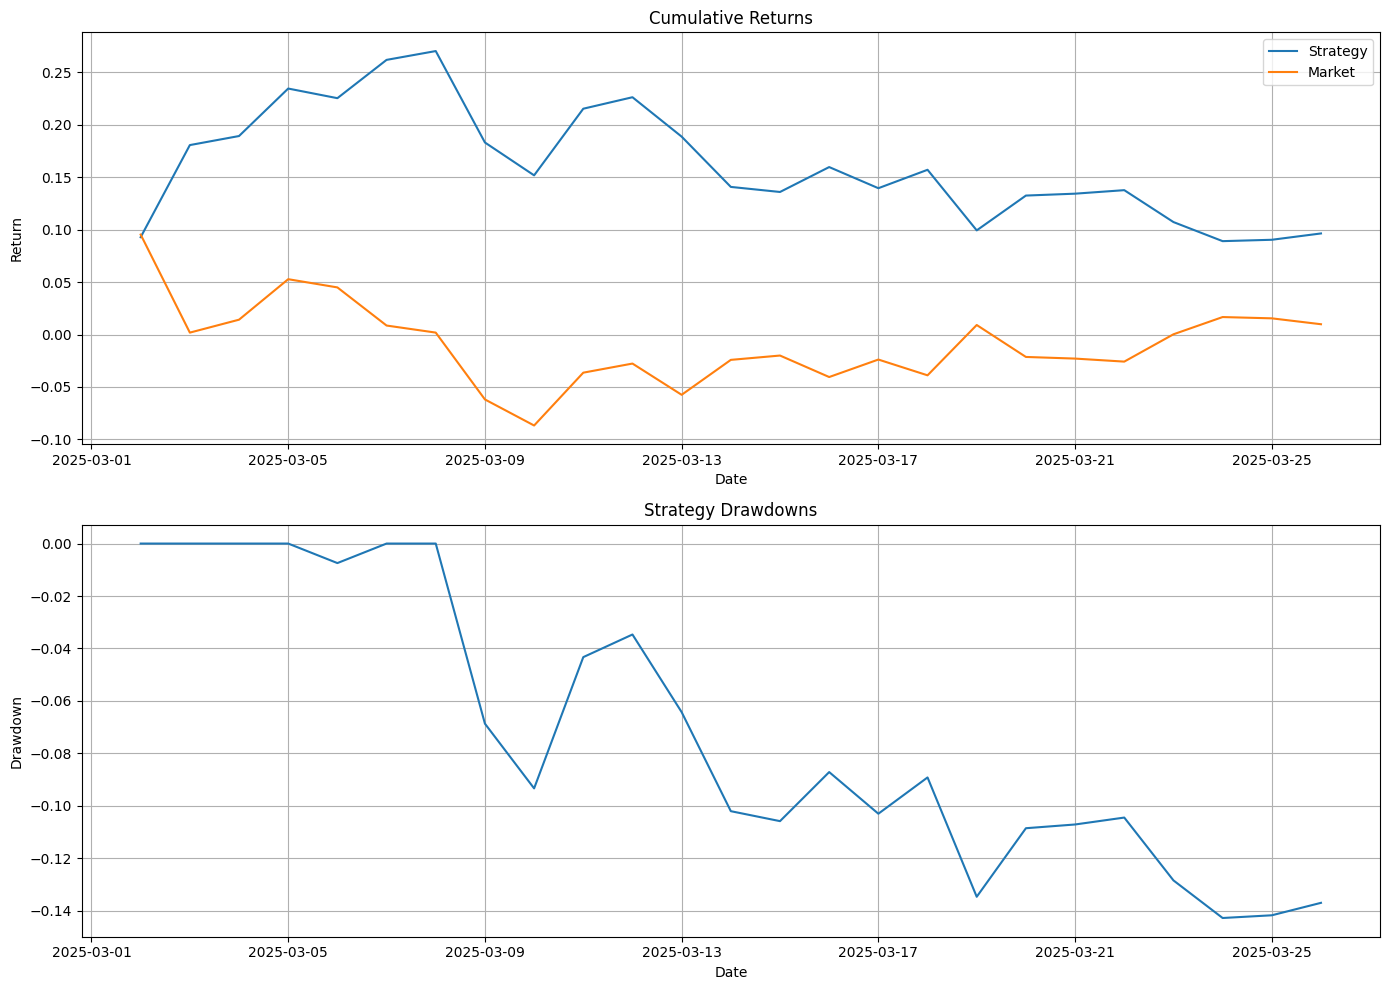

In [32]:
# Example usage
if __name__ == "__main__":
    model, backtest_results, metrics = main()